In [ ]:
<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: Илья Барышников. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №2
## <center> Визуальный анализ данных о сердечно-сосудистых заболеваниях

**В задании предлагается с помощью визуального анализа ответить на несколько вопросов по данным о сердечно-сосудистых заболеваниях. Данные использовались в соревновании [Ml Boot Camp 5](http://mlbootcamp.ru/round/12/sandbox/) (качать их не надо, они уже есть в репозитории).**

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/H5uTYg).**

В соревновании предлагалось определить наличие/отсутствие сердечно-сосудистых заболеваний (ССЗ) по результатам осмотра пациента.

**Описание данных.**

Объективные признаки:

 - Возраст (age)
 - Рост (height)
 - Вес (weight)
 - Пол (gender)
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее (ap_hi, ap_lo)
 - Холестерин (cholesterol)
 - Глюкоза (gluc)
 

Субъективные признаки (со слов пациентов):

 - Курение (smoke)
 - Употребление алкоголя (alco)
 - Физическая активность (active)
 
Целевой признак (который интересно будет прогнозировать):
 - Наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра (cardio)

Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

In [2]:
# подгружаем все нужные пакеты
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18 
    }
)

# Проведем небольшой EDA

In [3]:
train = pd.read_csv('../../data/mlbootcamp5_train.csv', sep=';',
                    index_col='id')

In [4]:
print('Размер датасета: ', train.shape)
train.head()

Размер датасета:  (70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Для начала всегда неплохо бы посмотреть на значения, которые принимают переменные.

Переведем данные в "Long Format"-представление и отрисуем с помощью [factorplot](https://seaborn.pydata.org/generated/seaborn.factorplot.html) количество значений, которые принимают категориальные переменные.

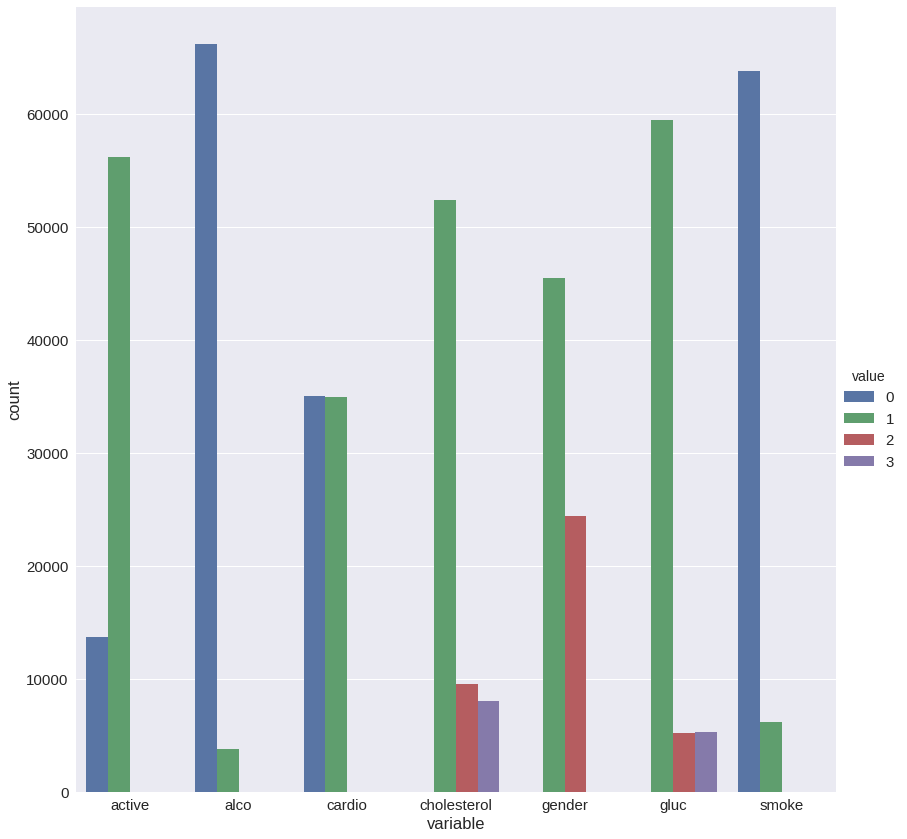

In [5]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active', 'cardio'])
train_uniques = pd.DataFrame(train_uniques.groupby(['variable', 
                                                    'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               data=train_uniques, kind='bar', size=12);

Видим, что классы целевой переменно сбалансированы, отлично!

Можно также разбить элементы обучающей выборки по значениям целевой переменной: иногда на таких графиках можно сразу увидеть самый значимый признак.

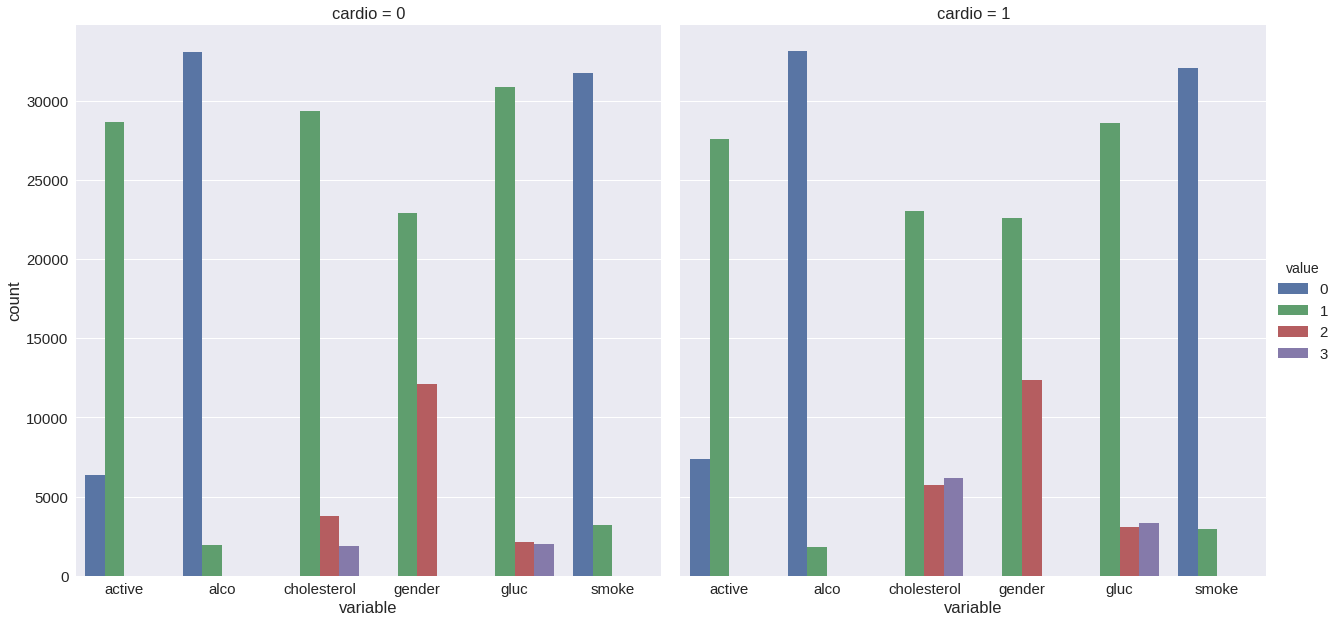

In [6]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active'], 
                        id_vars=['cardio'])
train_uniques = pd.DataFrame(train_uniques.groupby(['variable', 'value', 
                                                    'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=train_uniques, kind='bar', size=9);

Видим, что в зависимости от целевой переменной сильно меняется распределение холестерина и глюкозы. Совпадение?

**Немного статистики по уникальным значениям признаков.**

In [7]:
for c in train.columns:
    n = train[c].nunique()
    print(c)
    
    if n <= 3:
        print(n, sorted(train[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


*Итого:*
- Пять количественных признаков (без id)
- Семь категориальных
- 70000 элементов

---

# 1. Визуализируем корреляционную матрицу

Для того, чтобы лучше понять признаки в датасете, можно посчитать матрицу коэффициентов корреляции между признаками. <br>

Постройте [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html) корреляционной матрицы. Матрица формируется средствами *pandas*, со стандартным значением параметров.

###  1. Какие два признака больше всего коррелируют (по Пирсону) с признаком `gender` ?

- Cardio, Cholesterol
- **Height, Smoke**
- Smoke, Alco
- Height, Weight

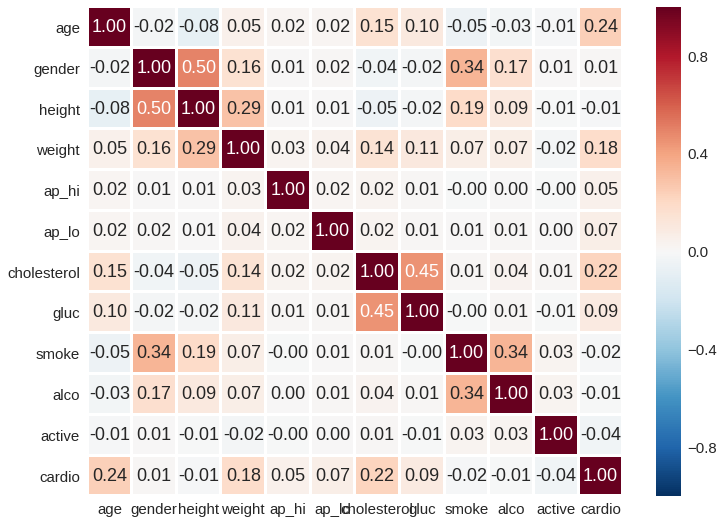

In [40]:
sns.heatmap(train.corr(), annot=True, fmt=".2f", linewidths=2);

---

# 2. Распределение роста для мужчин и женщин

Как мы увидели, в процессе исследования уникальных значений, пол кодируется значениями 1 и 2, расшифровка изначально не была нам дана в описании данных, но мы догадались, кто есть кто, посчитав средние значения роста (или веса) при разных значениях признака `gender`. Теперь сделаем то же самое, но графически. 

Постройте [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) для роста и пола. Используйте:
- hue – для разбивки по полу
- scale – для оценки количества каждого из полов 

Для корректной отрисовки, преобразуйте DataFrame в "Long Format"-представление с помощью функции melt в pandas.
<br>
[еще один пример](https://stackoverflow.com/a/41575149/3338479)

Постройте на одном графике два отдельных [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) роста, отдельно для мужчин и женщин. На нем разница будет более наглядной, но нельзя будет оценить количество мужчин/женщин.

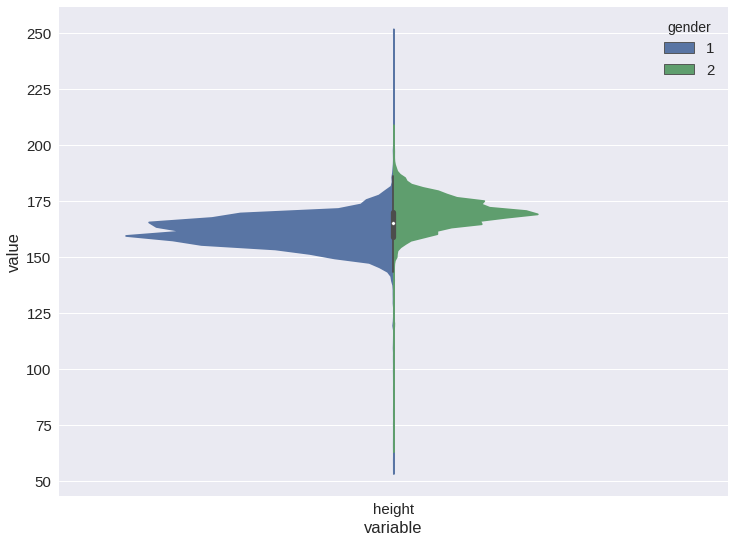

In [32]:
train_height = pd.melt(train, value_vars='height', id_vars='gender')
sns.violinplot(x='variable', y='value', hue='gender', scale='count', data=train_height, split=True);

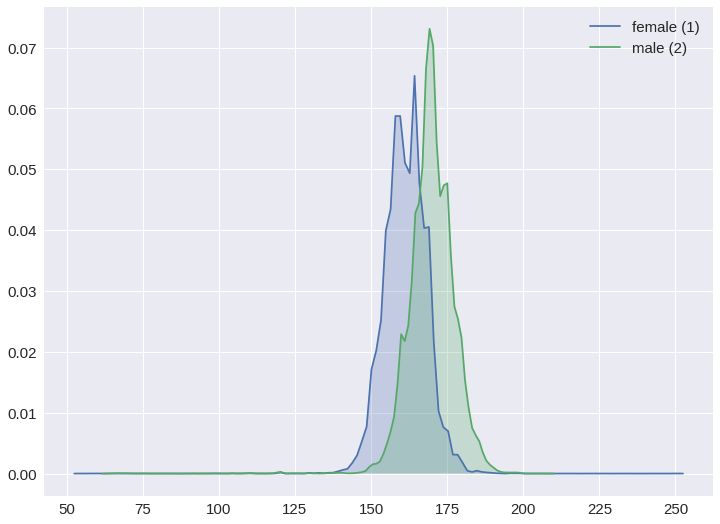

In [36]:
ax = plt.gca()
sns.kdeplot(train[train['gender'] == 1]['height'], ax=ax, shade=True, label="female (1)");
sns.kdeplot(train[train['gender'] == 2]['height'], ax=ax, shade=True, label="male (2)");

---

# 3. Ранговая корреляция

В большинстве случаев достаточно воспользоваться линейным коэффициентом корреляции *Пирсона* для выявления закономерностей в данных, но мы пойдем чуть дальше и используем ранговую корреляцию, которая поможет нам выявить пары, в которых меньший ранг из вариационного ряда одного признака всегда предшествует большему другого (или наоборот, в случае отрицательной корреляции).

** Постройте корреляционную матрицу, используя коэффициент Спирмена**

### 3.1 Какие признаки теперь больше всего коррелируют (по Спирмену) друг с другом?

- Height, Weight
- Age, Weight
- Cholesterol, Gluc
- Cardio, Cholesterol
- **Ap_hi, Ap_lo**
- Smoke, Alco

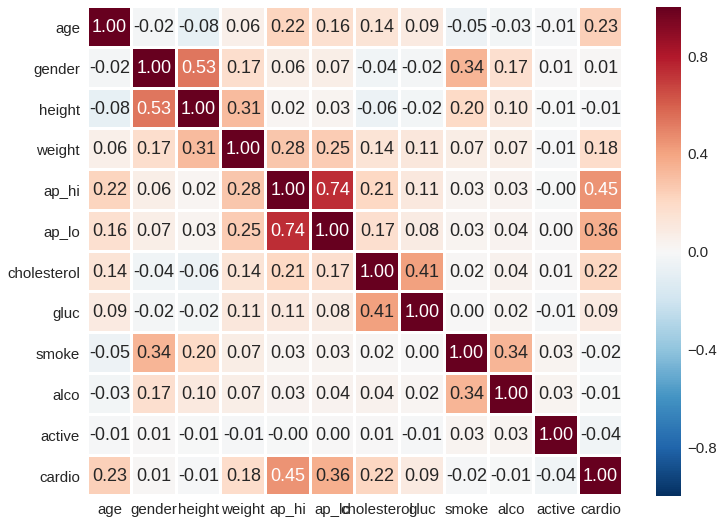

In [41]:
sns.heatmap(train.corr(method='spearman'), annot=True, fmt=".2f", linewidths=2);

### 3.2 Почему мы получили такое большое (относительно) значение ранговой корреляции у этих признаков?

- Неточности в данных (ошибки при сборе данных)
- Связь ошибочна, переменные никак не должны быть связаны друг с другом
- **Природа данных**

In [54]:
train[['ap_hi', 'ap_lo']].describe()

,ap_hi,ap_lo
count,70000.000000,70000.000000
mean,128.817286,96.630414
std,154.011419,188.472530
min,-150.000000,-70.000000
25%,120.000000,80.000000
50%,120.000000,80.000000
75%,140.000000,90.000000
max,16020.000000,11000.000000


In [56]:
#Также есть некорректные значения
train[train['ap_hi'] <= train['ap_lo']]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
314,17489,2,183,98.0,160,1100,1,2,1,0,1,1
334,21932,2,157,60.0,160,1000,2,1,0,0,0,1
357,18217,1,150,83.0,140,800,1,1,0,0,1,1
458,23407,1,176,63.0,160,1000,2,2,0,0,0,1
482,18704,1,154,81.0,140,1000,2,1,0,0,1,1
680,15226,1,150,95.0,150,1033,1,1,0,0,1,1
681,19099,1,156,65.0,120,150,2,1,0,0,1,0
805,20430,2,173,101.0,200,1000,1,1,0,0,1,1
815,21281,1,168,78.0,14,90,2,1,0,0,1,1


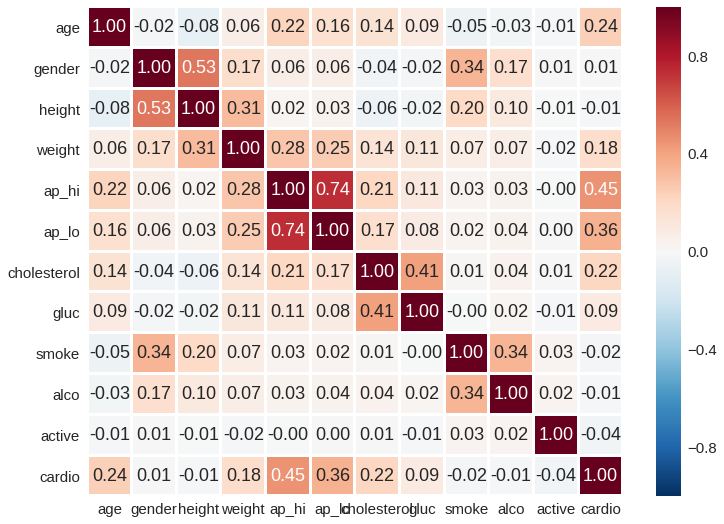

In [47]:
sns.heatmap(train[train['ap_hi'] > train['ap_lo']].corr(method='spearman'), annot=True, fmt=".2f", linewidths=2);

---

# 4. Совместное распределение признаков

Постройте совместный график распределения [jointplot](http://seaborn.pydata.org/generated/seaborn.jointplot.html) двух наиболее коррелирующих между собой признаков (по Спирмену).

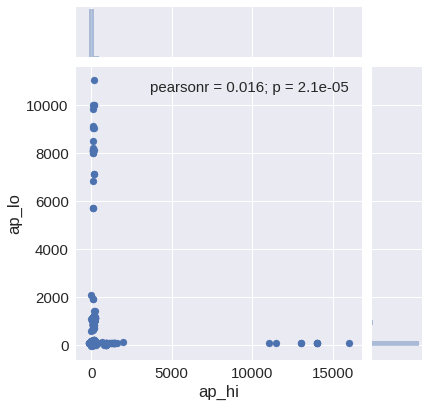

In [67]:
sns.jointplot(x='ap_hi', y='ap_lo', data=train);

Кажется, наш график получился неинформативным из-за выбросов в значениях. Постройте тот же график, но с логарифмической шкалой.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


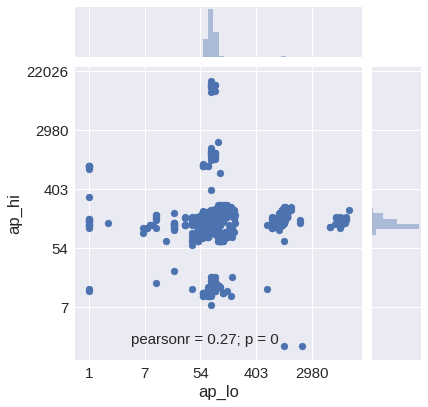

In [76]:
g = sns.jointplot(x=np.log1p(train['ap_lo']), y=np.log1p(train['ap_hi']));

# -------------------- #

"""Сетка"""
g.ax_joint.grid(True) 

"""Преобразуем логарифмические значения на шкалах в реальные"""
g.ax_joint.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(round(int(np.exp(x))))))
g.ax_joint.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(round(int(np.exp(x))))))
#g.ax_joint.set_xscale('log')
#g.ax_joint.set_yscale('log')

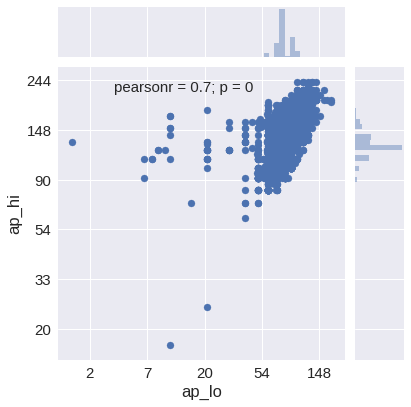

In [83]:
train_clean = train[(train['ap_hi'] > train['ap_lo']) 
                    & (train['ap_hi'] > 0) 
                    & (train['ap_lo'] > 0) 
                    & (train['ap_hi'] <= 300) ]
g = sns.jointplot(x=np.log1p(train_clean['ap_lo']), y=np.log1p(train_clean['ap_hi']));

# -------------------- #

"""Сетка"""
g.ax_joint.grid(True) 

"""Преобразуем логарифмические значения на шкалах в реальные"""
g.ax_joint.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(round(int(np.exp(x))))))
g.ax_joint.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(round(int(np.exp(x))))))
#g.ax_joint.set_xscale('log')
#g.ax_joint.set_yscale('log')

### 4.1 Сколько четко выраженных кластеров получилось на  совместном графике выбранных признаков, с логарифмической шкалой?

- 1
- 2
- 3
- **больше трех**

In [85]:
# Ваш код здесь

---

# 5. Barplot

Посчитаем, сколько полных лет было респондентам на момент их занесения в базу.

In [70]:
train['age_years'] = (train['age'] // 365.25).astype(int)

Постройте [Countplot](http://seaborn.pydata.org/generated/seaborn.countplot.html), где на оси абсцисс будет отмечен возраст, на оси ординат – количество. Каждое значение возраста должно иметь два столбца, соответствующих количеству человек каждого класса **cardio** данного возраста.

### 5. В каком возрасте количество пациентов с ССЗ  впервые становится больше, чем здоровых?
- 44
- **53**
- 64
- 70

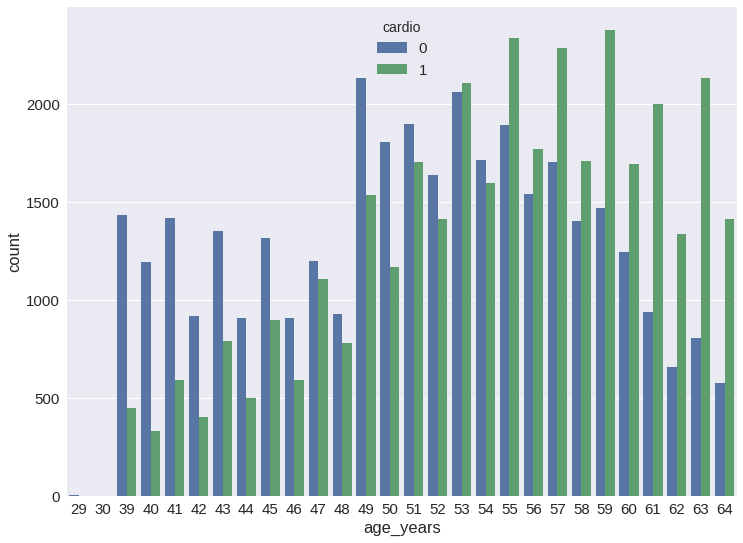

In [73]:
sns.countplot(x='age_years', hue='cardio', data=train);